Apprach this problem from 2 different angles. First use only clear images of pets and match it with the pawpularity score. Alternatively, use tabular data provided use it make a prediction of pawpularity score.
Use additional models to analyse text data and its meaning and its correlation to pawpularity. Consider a transformer network for this purpose.

In [8]:
import numpy as np
import torch
from PIL import Image
from torchvision import models
import pandas as pd
from torchvision import transforms

In [47]:
from matplotlib import pyplot as plt

In [1]:
DATASET_PATH = '../../datasets/petfinder-pawpularity-score/'

### Load Dataset

In [3]:
train = pd.read_csv(DATASET_PATH + 'train.csv')
train.head()


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


filter collages and text

In [4]:
def read_image_paths(dataset_dir, data_df):
    images = data_df['Id'].to_list()
    labels = data_df['Pawpularity'].to_list()
    image_paths = [dataset_dir + "train/" + image + '.jpg' for image in images]
    return image_paths, labels

images_paths, labels = read_image_paths(DATASET_PATH, train)


In [ ]:
Image.open(images_paths[0])


In [57]:
def read_image_generator(image_paths, labels, batch_size, device):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    preprocessing = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize,
                                ])
    batch_imgs = []
    batch_labels = []
    batch_counter = 0
    for img_path, label in zip(image_paths, labels):
        img = Image.open(img_path)
        img_preprocessed = preprocessing(img)
        batch_imgs.append(img_preprocessed)
        batch_labels.append(label)
        batch_counter += 1
        # print(batch_counter)
        if batch_counter == batch_size:
            batch_imgs = torch.stack(batch_imgs).type(torch.FloatTensor)
            batch_labels = torch.tensor(batch_labels).type(torch.FloatTensor).unsqueeze(1)
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            yield batch_imgs, batch_labels
            batch_imgs = []
            batch_labels = []
            batch_counter = 0



    

Test the image generator

In [58]:
images_paths, labels = read_image_paths(DATASET_PATH, train)
N = 300
images_paths = images_paths[:N]
labels = labels[:N]

total = 0
correct = 0
batch_size = 32
# with torch.no_grad():
with torch.no_grad():
    for img_arr, label in read_image_generator(images_paths, labels, batch_size=batch_size, device='cpu'):
        print(img_arr.shape, label.shape)
        print(img_arr.dtype, label.dtype)

        print(resnet50(img_arr).shape)

        break

        total += batch_size



torch.Size([32, 3, 224, 224]) torch.Size([32, 1])
torch.float32 torch.float32
torch.Size([32, 1])


### Dataset Analysis and Overview

General analytics of the images. Which images pootentially can look good and which ones does not.
Does additional information or collages have a higher pawpularity score?
Does text make your pet look better?
Can we analyse the text on the image and whether the meaning of the text has correlation with pawpularity score?

Dataset contans collages and text. It worth checking what the meaning of the text and detect collages. Can we split collages into multiple images?

### Test torch accuracy using ImageNet. Need to download the dataset
You need to download ImageNet validation dataset.

### Use ImageNet pretrained model and fine tune them on the dataset
Do this only for clear images without any text or collages.

Split Train into train and validation

Fine-tune model on the dataset

In [43]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
resnet50.fc = torch.nn.Linear(2048, 1) # replace the last layer with a single output layer



In [44]:
images_paths, labels = read_image_paths(DATASET_PATH, train)
batch_size = 64
N = batch_size * 10
images_paths = images_paths[:N]
labels = labels[:N]

total = 0
correct = 0
# with torch.no_grad():
optimiser = torch.optim.Adam(resnet50.parameters(), lr=0.0001) # optimise with low learning rate
loss_fn = torch.nn.MSELoss()

losses = []

epochs = 10

for epoch in range(epochs):
    print("Epoch: ", epoch)
    for img_arr, label in read_image_generator(images_paths, labels, batch_size=batch_size, device='cpu'):
        out = resnet50(img_arr)
        # print(label.dtype)
        loss = loss_fn(out, label)

        # print(loss.dtype)
        loss.backward()

        optimiser.step()

        optimiser.zero_grad()

        losses.append(loss.item())



Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [50]:
np.min(labels), np.max(labels)

(2, 100)

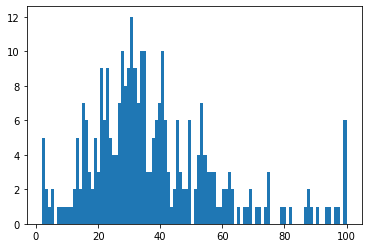

In [73]:
hist = plt.hist(labels, bins=100)

In [52]:
losses = np.array(losses)
np.min(losses/32), np.max(losses/32)

(6.0240888595581055, 66.2159423828125)

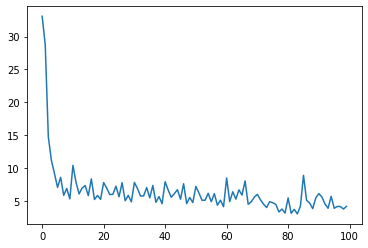

In [53]:
plt.plot(np.array(losses)/batch_size)

Test Umi

In [59]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                            ])

In [71]:
umi_img = Image.open("884e5c17-98de-482d-9c14-d83afa441d41_Original.jpg")
umi_img = Image.open("4abd0d9c-81e4-45ab-9776-c8e168f68dbd_Original.jpg")

umi_img = preprocessing(umi_img).unsqueeze(0)
with torch.no_grad():
    out = resnet50(umi_img)
    print(out)
    print(out.shape)
    print(out.dtype)

tensor([[32.0172]])
torch.Size([1, 1])
torch.float32


### create a simple FC model for tabular data and train it to match pawpularity
Is there a patter between the collages and the text?


### Split collages into a number of images
Analyse those images and compute average pawpularity score for the collage. If there is text in the collage. Get the meaning of the text.

In [ ]:
print(img.shape)